In [19]:
# /*==========================================================================================*\
# **                        _           _ _   _     _  _         _                            **
# **                       | |__  _   _/ | |_| |__ | || |  _ __ | |__                         **
# **                       | '_ \| | | | | __| '_ \| || |_| '_ \| '_ \                        **
# **                       | |_) | |_| | | |_| | | |__   _| | | | | | |                       **
# **                       |_.__/ \__,_|_|\__|_| |_|  |_| |_| |_|_| |_|                       **
# \*==========================================================================================*/


# -----------------------------------------------------------------------------------------------
# Author: Bùi Tiến Thành - Tien-Thanh Bui (@bu1th4nh)
# Title: playground_data.ipynb
# Date: 2024/11/07 14:39:32
# Description: 
# 
# (c) 2024 bu1th4nh. All rights reserved. 
# Written with dedication in the University of Central Florida, EPCOT and the Magic Kingdom.
# -----------------------------------------------------------------------------------------------

from s3fs import S3FileSystem
import numpy as np
import pandas as pd 
import sys

sys.path.append('../../')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, average_precision_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from tqdm import tqdm
from downstream.survival import surv_analysis

key = 'bu1th4nh'
secret = 'ariel.anna.elsa'
endpoint_url = 'http://localhost:9000'

s3 = S3FileSystem(
    anon=False, 
    endpoint_url=endpoint_url,
    key=key,
    secret=secret,
    use_ssl=False
)
storage_options = {
    'key': key,
    'secret': secret,
    'endpoint_url': endpoint_url,
}
storage_option = storage_options
DATA_PATH = 's3://datasets/LungCancer/processed_3_omics_mRNA_miRNA_methDNA'
SURV_PATH = 's3://datasets/LungCancer/survivalanalysis_testdata_3_omics_mRNA_miRNA_methDNA'
# DATA_PATH = 's3://datasets/LungCancer/processed_2_omics_mRNA_miRNA'
# SURV_PATH = 's3://datasets/LungCancer/survivalanalysis_testdata_2_omics_mRNA_miRNA'



def select_top_features_by_variance(df, top_n=1000):
    variances = df.var(axis=1)
    top_features = variances.nlargest(top_n).index
    return df.loc[top_features]

In [20]:
if 'methDNA' in DATA_PATH:
    methDNA = pd.read_parquet(f'{DATA_PATH}/methDNA.parquet', storage_options=storage_option)
miRNA = pd.read_parquet(f'{DATA_PATH}/miRNA.parquet', storage_options=storage_option)
mRNA = pd.read_parquet(f'{DATA_PATH}/mRNA.parquet', storage_options=storage_option)



# if 'methDNA' in DATA_PATH: methDNA = select_top_features_by_variance(methDNA, top_n=1000)
# miRNA = select_top_features_by_variance(miRNA, top_n=1000)
# mRNA = select_top_features_by_variance(mRNA, top_n=1000)


if 'methDNA' in DATA_PATH:
    Jasmine = pd.concat([mRNA, miRNA, methDNA], axis=0)
else:
    Jasmine = pd.concat([mRNA, miRNA], axis=0)

Jasmine.to_parquet(f'{DATA_PATH}/allinone.parquet', storage_options=storage_option)

In [ ]:
# aio_data = pd.read_parquet(f'{DATA_PATH}/allinone_top1kvariance.parquet', storage_options=storage_option).T
# survival_data = pd.read_parquet(f'{SURV_PATH}/survival.parquet', storage_options=storage_option)



# train_sample_ids, test_sample_ids = train_test_split(
#     survival_data.index, 
#     test_size=0.2, 
# )




# surv_baseline = surv_analysis(
#     aio_data, 
#     train_sample_ids,
#     survival_data.loc[train_sample_ids],
#     test_sample_ids,
#     survival_data.loc[test_sample_ids],
#     'Overall Survival Status',
#     'Overall Survival (Months)',
#     return_kmf_object=True,
#     alpha=0.05,
# )

Text(0.03, 0.05, 'p-value: 0.22692')

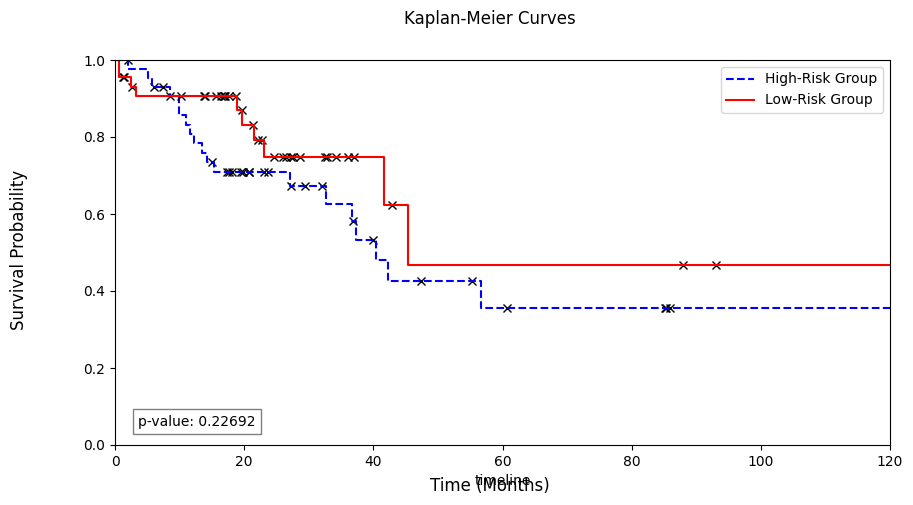

In [ ]:
# # Create a new figure
# fig, ax = plt.subplots(figsize=(10, 5))

# # Plot the Kaplan-Meier embedding survival curves
# surv_baseline['kmf_high'].plot(ax=ax, color='blue', linestyle='--', show_censors = True, ci_show = False, censor_styles={'ms': 6, 'marker': 'x', 'markeredgecolor': '#000000'})
# surv_baseline['kmf_low'].plot(ax=ax, color='red', linestyle='-',  show_censors = True, ci_show = False, censor_styles={'ms': 6, 'marker': 'x', 'markeredgecolor': '#000000'})



# # Add titles
# fig.suptitle(f'Kaplan-Meier Curves')
# fig.supxlabel('Time (Months)')
# fig.supylabel('Survival Probability')


# # Add legend
# ax.legend(loc='best')

# # Add x and y axis limits
# ax.set_xlim(0, 120)
# ax.set_ylim(0, 1)

# # Add p-value to the plot
# p_value = surv_baseline['logrank_result'].p_value
# ax.text(0.03, 0.05, f'p-value: {p_value:.5f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

In [ ]:
# Moana = pd.read_parquet(f'{DATA_PATH}/allinone.parquet', storage_options=storage_option)

# Moana.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21229 entries, A1BG to cg24453353
Columns: 295 entries, TCGA-04-1348-01 to TCGA-61-2113-01
dtypes: float64(295)
memory usage: 47.9+ MB
